# Finding Prominent Keywords in Movies

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import os
from os import path
import random

In [212]:
movies_data = pd.read_csv('Datasets/cleaned-movies-metainformation.csv')
keywords_data = pd.read_csv('Datasets/keywords.csv')

In [213]:
movies_data = movies_data[['id', 'title', 'genres']]

Below are three functions used to gather data. One was to turn the string of a list of dictornaries into a column with the information intended for the column. Another other is simply to query the dataframe depending on if a substring was contained in that column. The third is to convert a string into a list.

In [214]:
def makeColumn(series, key):
    count = 0
    col = []
    string = ""
    for lis in series:
        li = lis.strip('][').split(', ')
        for dic in li:
            di = dic.strip('}{').replace("'", '').split(':')
            if di[0] == key:
                string += di[1]
                string += ","
        col.append(string)
        string = ""
    return pd.Series(col)

In [215]:
def contains(ser, word):
    li = []
    for i in ser:
        if word in i:
            li.append(True)
        else:
            li.append(False)
    return li

In [216]:
def convert(string): 
    li = list(string.split(","))
    li = [x.strip(' ') for x in li]
    return li

In [217]:
makeColumn(movies_data['genres'], 'name')

0          Animation, Comedy, Family,
1         Adventure, Fantasy, Family,
2                    Romance, Comedy,
3             Comedy, Drama, Romance,
4                             Comedy,
                     ...             
43981                  Drama, Family,
43982                          Drama,
43983        Action, Drama, Thriller,
43984                                
43985                                
Length: 43986, dtype: object

In [218]:
movies_data['genres'] = makeColumn(movies_data['genres'], 'name')

In [219]:
keywords_data['keywords'] = makeColumn(keywords_data['keywords'], 'name')

In [220]:
movies_data.head()

,id,title,genres
0,862,Toy Story,"Animation, Comedy, Family,"
1,8844,Jumanji,"Adventure, Fantasy, Family,"
2,15602,Grumpier Old Men,"Romance, Comedy,"
3,31357,Waiting to Exhale,"Comedy, Drama, Romance,"
4,11862,Father of the Bride Part II,"Comedy,"


In [221]:
keywords_data.head()

,id,keywords
0,862,"jealousy, toy, boy, friendship, friends, riva..."
1,8844,"board game, disappearance, ""based on children..."
2,15602,"fishing, best friend, duringcreditsstinger, o..."
3,31357,"based on novel, interracial relationship, sin..."
4,11862,"baby, midlife crisis, confidence, aging, daug..."


In [222]:
movies_data = movies_data.merge(keywords_data, on="id")

In [223]:
movies_data.head()

,id,title,genres,keywords
0,862,Toy Story,"Animation, Comedy, Family,","jealousy, toy, boy, friendship, friends, riva..."
1,8844,Jumanji,"Adventure, Fantasy, Family,","board game, disappearance, ""based on children..."
2,15602,Grumpier Old Men,"Romance, Comedy,","fishing, best friend, duringcreditsstinger, o..."
3,31357,Waiting to Exhale,"Comedy, Drama, Romance,","based on novel, interracial relationship, sin..."
4,11862,Father of the Bride Part II,"Comedy,","baby, midlife crisis, confidence, aging, daug..."


We then go through the genres and find all the different types.

In [224]:
#make array of genres
genre_list = []
for i in movies_data.genres:
    genre_list = genre_list + convert(i)
movie_genres = np.unique(genre_list)

In [225]:
movie_genres

array(['', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype='<U15')

## Making the Word Clouds

I referenced [Generating Word Clouds in Python](https://www.geeksforgeeks.org/generating-word-cloud-python/) to create my Word Clouds. Below is the function I used to create each word cloud, as well as the generic stopwords provided by the `word cloud` module.

In [226]:
stopwords = set(STOPWORDS) 
stopwords.add("based")
stopwords.add("independent film")
stopwords.add("independent")
stopwords.add("film")
stopwords.add("woman")
stopwords.add("director")

def getKeyword(col):
    comment_words = ''
    for val in col:
        tokens = val.split() 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        comment_words += " ".join(tokens)+" "
    return comment_words

Using the [Colored By Group](https://amueller.github.io/word_cloud/auto_examples/colored_by_group.html) code by Andreas Mueller

In [227]:
from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt


class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

## Action Word Cloud

In [228]:
action_movies = movies_data[contains(movies_data['genres'], 'Action')]

In [330]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
action_coloring = np.array(Image.open(path.join(d, "Visuals/action.jpg")))

In [233]:
color_to_words = {
    # words below will be colored with a black color function
    '#000000': ['spy', 'love', 'shootout', 'child',
                'car chase', 'serial killer'],
    # will be colored with a blue single color function
    '#288CEA': ['marital', 'arts','police', 'prison', 'dystopia', 'sequel', 'murder', 'world war', 'sword',
               'terrorist', 'sport', 'violence']
}
action_default_color = 'red'
action_color_func = GroupedColorFunc(color_to_words, action_default_color)

In [321]:
actioncloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                mask=action_coloring,
                stopwords = stopwords,
                min_font_size = 10).generate(getKeyword(action_movies.keywords))

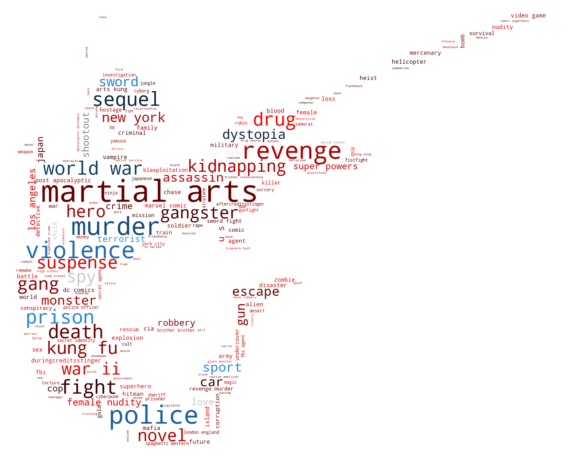

In [322]:
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(actioncloud.recolor(color_func=action_color_func, random_state=3), interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
actioncloud.to_file('actioncloud.png')

## Romance Word Cloud

In [236]:
romance_movies = movies_data[contains(movies_data['genres'], 'Romance')]

In [331]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
heart_coloring = np.array(Image.open(path.join(d, "Visuals/heart.png")))

In [325]:
romcloud = WordCloud(width = 800, height = 800, 
                background_color ='#F4FDFE',
                mask=heart_coloring,
                stopwords = stopwords,
                min_font_size = 10).generate(getKeyword(romance_movies.keywords))

image_colors = ImageColorGenerator(heart_coloring)

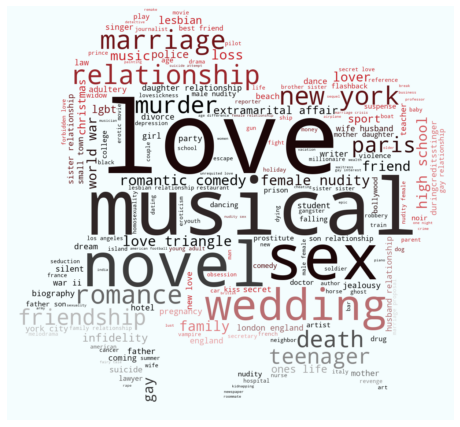

In [328]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(romcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
romcloud.to_file('romancecloud.png')

## Horror Word Cloud

In [240]:
horror_movies = movies_data[contains(movies_data['genres'], 'Horror')]

In [332]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
horror_coloring = np.array(Image.open(path.join(d, "Visuals/skull.png")))

In [307]:
color_to_words = {
    # words below will be colored with a black color function
    'red': ['monster', 'zombie', 'suspense', 'female',
                'nudity', 'sequel']
}
horror_default_color = 'white'
horror_color_func = GroupedColorFunc(color_to_words, horror_default_color)

In [308]:
horrorcloud = WordCloud(width = 800, height = 800, 
                background_color ='black',
                mask=horror_coloring,
                stopwords = stopwords, 
                min_font_size = 5).generate(getKeyword(horror_movies.keywords))

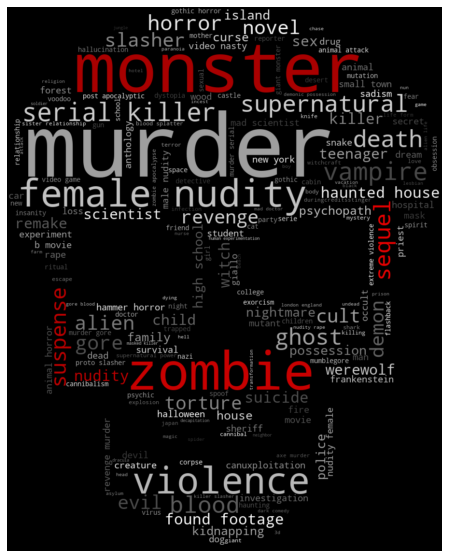

In [310]:
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(horrorcloud.recolor(color_func=horror_color_func), interpolation="bilinear")
plt.axis("off")
plt.show()

In [327]:
horrorcloud.to_file('horrorcloud.png')

## General Word Cloud

In [334]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
movie_coloring = np.array(Image.open(path.join(d, "Visuals/movie.png")))
#image_colors = ImageColorGenerator(movie_coloring)

In [170]:
stopwords = set(STOPWORDS)
moviecloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                mask=movie_coloring,
                stopwords = stopwords,
                min_font_size = 10).generate(getKeyword(movies_data.keywords))

#image_colors = ImageColorGenerator(movie_coloring)

In [208]:
color_to_words = {
    # words below will be colored with a black color function
    '#F1E00E': ['woman director', 'independent film']
}
movie_default_color = '#0E1967'
movie_color_func = GroupedColorFunc(color_to_words, movie_default_color)

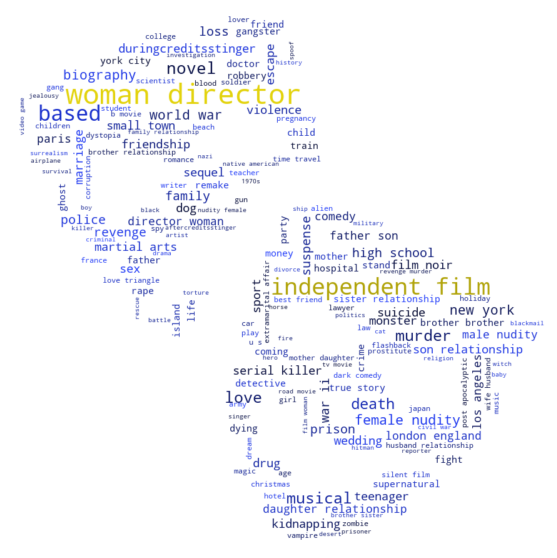

In [209]:
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(moviecloud.recolor(color_func=movie_color_func), interpolation="bilinear")
plt.axis("off")
plt.show()

In [329]:
moviecloud.to_file('moviecloud.png')